In [1]:
import os
import os.path as osp
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
from skimage.io import imsave, imread
from skimage import img_as_ubyte, img_as_float
import sys
# sys.path.insert(0, '../utils')


In [29]:
def imshow_pair(im, gdt, vmin1=0, vmax1=1, vmin2=0, vmax2=1):
    f, ax = plt.subplots(1, 2, figsize=(10,6))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        if vmin1==None:
            ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
        else:
            ax[0].imshow(np_im, cmap='gray', vmin=vmin1, vmax=vmax1),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        if vmin2==None:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
        else:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray', vmin=vmin2, vmax=vmax2), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [3]:
import torch
import torchvision.transforms as tr
from utils.get_loaders import get_train_val_loaders, get_train_val_loaders_SK 
from utils.get_loaders import get_train_val_datasets, get_train_val_datasets_SK
from models.get_model import get_arch

In [4]:
csv_train = 'data/DRIVE/train_av.csv'
csv_val = csv_train.replace('train', 'val')

In [5]:
idd = 50
idd2 = 250
off1 = 100
off2 = 100

In [6]:
# imshow_pair(vessels[idd:idd+off1,idd2:idd2+off2], sk_art[idd:idd+off1,idd2:idd2+off2])
# imshow_pair(vessels[idd:idd+off1,idd2:idd2+off2], sk_vein[idd:idd+off1,idd2:idd2+off2])

In [7]:
n_classes=4
label_values=[0, 85, 170, 255]

In [8]:
train_ds_SK, val_ds_SK = get_train_val_datasets_SK(csv_path_train=csv_train,  csv_path_val=csv_val, 
                                             tg_size=(512,512), label_values=label_values)

In [9]:
x,y, sk_art, sk_vein = train_ds_SK[0]

In [10]:
torch.unique(y),torch.unique(sk_art), torch.unique(sk_vein)

(tensor([0, 1, 2, 3]), tensor([0, 1]), tensor([0, 1]))

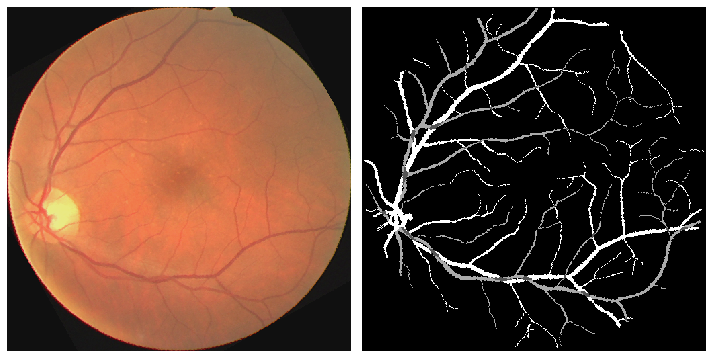

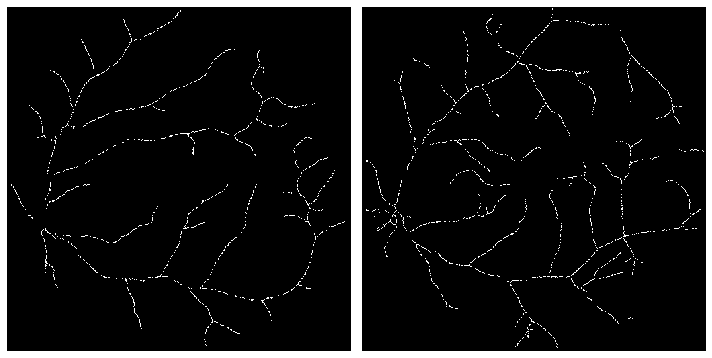

In [11]:
imshow_pair(x.numpy().transpose(1,2,0), y[0].numpy())
imshow_pair(sk_art[0].numpy(), sk_vein[0].numpy())

In [12]:
train_loader, val_loader = get_train_val_loaders_SK(csv_path_train=csv_train, 
                                                 csv_path_val=csv_val, 
                                                 batch_size=2, tg_size=(512,512), 
                                                 label_values=label_values, num_workers=8)

In [13]:
print('* Instantiating a {} model'.format('wnet'))
model = get_arch('big_wnet', n_classes=n_classes)

* Instantiating a wnet model


In [14]:
from utils.model_saving_loading import load_model
model, stats = load_model(model, 'experiments/big_wnet_drive_av/', 'cpu')

In [15]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')

In [173]:
(inputs, labels, sk_art, sk_vein) = next(iter(val_loader))

In [174]:
labels.shape

torch.Size([2, 1, 512, 512])

In [18]:
logits_aux, logits = model(inputs)
probs = torch.nn.Softmax(dim=1)(logits).detach()

In [24]:
def compute_tv(logits):

    preds = torch.nn.Softmax(dim=1)(logits)

    tv_l = torch.abs(torch.sub(preds, torch.roll(preds, shifts=1, dims=3)))
    tv_r = torch.abs(torch.sub(preds, torch.roll(preds, shifts=-1, dims=3)))
    tv_lu = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(1, 1), dims=(2, 3))))
    tv_rd = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(-1, -1), dims=(2, 3))))

    tv_u = torch.abs(torch.sub(preds, torch.roll(preds, shifts=1, dims=2)))
    tv_d = torch.abs(torch.sub(preds, torch.roll(preds, shifts=-1, dims=2)))
    tv_ru = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(1, -1), dims=(2, 3))))
    tv_dl = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(-1, 1), dims=(2, 3))))
    # take mean across orientations
    tv = torch.mean(torch.stack([tv_l, tv_r, tv_lu, tv_rd, tv_u, tv_d, tv_ru, tv_dl], dim=0), dim=0)

    return tv

In [184]:
def compute_tv2(logits, labels):

    probs = torch.nn.Softmax(dim=1)(logits)
    labels_oh = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
    masked_probs_high = probs.clone()
    masked_probs_high[~labels_oh] = 3  # assign high values outside labels

    masked_tv_l = torch.sub(probs, torch.roll(masked_probs_high, shifts=1, dims=-1))
    masked_tv_l = torch.clamp(masked_tv_l, min=0, max=1)

    masked_tv_r = torch.sub(probs, torch.roll(masked_probs_high, shifts=-1, dims=-1))
    masked_tv_r = torch.clamp(masked_tv_r, min=0, max=1)

    masked_tv_u = torch.sub(probs, torch.roll(masked_probs_high, shifts=-1, dims=-2))
    masked_tv_u = torch.clamp(masked_tv_u, min=0, max=1)

    masked_tv_d = torch.sub(probs, torch.roll(masked_probs_high, shifts=1, dims=-2))
    masked_tv_d = torch.clamp(masked_tv_d, min=0, max=1)

    masked_tv = torch.mean(torch.stack([masked_tv_u, masked_tv_d, masked_tv_l, masked_tv_r], axis=0), dim=0)

    return masked_tv

In [182]:
tv = compute_tv(logits).detach()

In [186]:
labels.shape

torch.Size([2, 1, 512, 512])

In [187]:
tv2 = compute_tv2(logits, labels.squeeze()).detach()

In [188]:
bb=0
ll=2

idd = 280
idd2 = 180
off1 = 100
off2 = 100

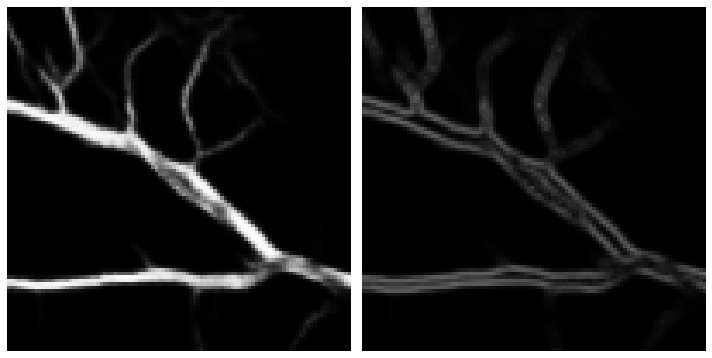

In [189]:
imshow_pair(probs[bb,ll,idd:idd+off1,idd2:idd2+off2], tv[bb,ll,idd:idd+off1,idd2:idd2+off2])

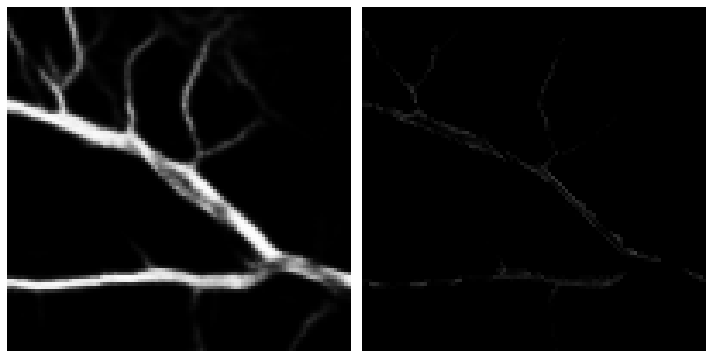

In [190]:
imshow_pair(probs[bb,ll,idd:idd+off1,idd2:idd2+off2], tv2[bb,ll,idd:idd+off1,idd2:idd2+off2])

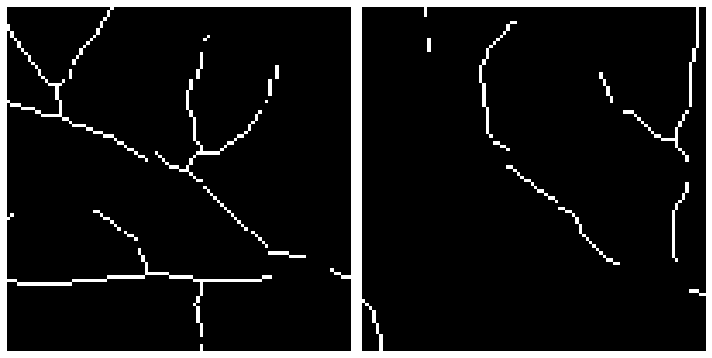

In [61]:
imshow_pair(sk_art[bb,0,idd:idd+off1,idd2:idd2+off2], sk_vein[bb,0,idd:idd+off1,idd2:idd2+off2])

In [70]:
stacked_sk = torch.stack([torch.zeros_like(sk_art),torch.zeros_like(sk_vein),sk_art,sk_vein], dim=1).squeeze()
tv2 = torch.mul(tv, stacked_sk)

In [84]:
bb=0
ll=3

idd = 0
idd2 = 0
off1 = 512
off2 = 512

In [94]:
labels.shape

torch.Size([2, 1, 512, 512])

In [95]:
perfect_logits = 100*torch.stack([(labels==0),(labels==1),(labels==2),(labels==3)],dim=1).squeeze().float()
perfect_probs = torch.nn.Softmax(dim=1)(perfect_logits)
error = torch.abs(perfect_probs-probs)

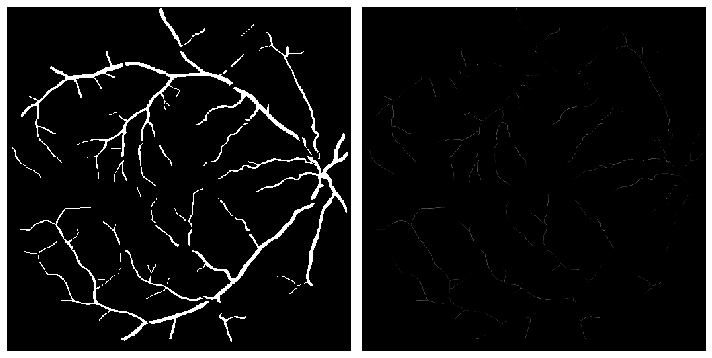

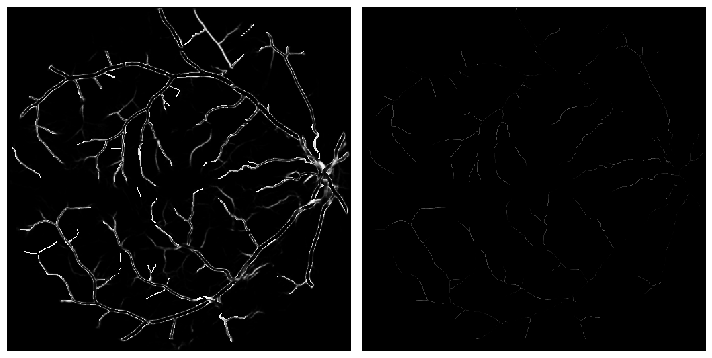

In [96]:
imshow_pair(perfect_probs[bb,ll,idd:idd+off1,idd2:idd2+off2], tv2[bb,ll,idd:idd+off1,idd2:idd2+off2])
imshow_pair(error[bb,ll,idd:idd+off1,idd2:idd2+off2], tv2[bb,ll,idd:idd+off1,idd2:idd2+off2])

In [169]:
class MaskedTV(torch.nn.Module):
    def __init__(self, ignore_background=True, reduction='mean'):
        super(MaskedTV, self).__init__()
        self.reduction = reduction
        self.ignore_background = ignore_background

    def compute_tv(self, logits, labels):

        probs = torch.nn.Softmax(dim=1)(logits)
        labels_oh = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
        masked_probs_high = probs.clone()
        masked_probs_high[~labels_oh] = 3  # assign high values outside labels

        masked_tv_l = torch.sub(probs, torch.roll(masked_probs_high, shifts=1, dims=-1))
        masked_tv_l = torch.clamp(masked_tv_l, min=0, max=1)

        masked_tv_r = torch.sub(probs, torch.roll(masked_probs_high, shifts=-1, dims=-1))
        masked_tv_r = torch.clamp(masked_tv_r, min=0, max=1)

        masked_tv_u = torch.sub(probs, torch.roll(masked_probs_high, shifts=-1, dims=-2))
        masked_tv_u = torch.clamp(masked_tv_u, min=0, max=1)

        masked_tv_d = torch.sub(probs, torch.roll(masked_probs_high, shifts=1, dims=-2))
        masked_tv_d = torch.clamp(masked_tv_d, min=0, max=1)

        masked_tv = torch.mean(torch.stack([masked_tv_u, masked_tv_d, masked_tv_l, masked_tv_r], axis=0), dim=0)

        return masked_tv

    def forward(self, logits, labels, sk_art, sk_vein, **kwargs):
        # assumes logits is bs x n_classes H x W,
        #         labels is bs x H x W containing integer values in [0,...,n_classes-1]
        
        sk = torch.stack([torch.zeros_like(sk_art),torch.zeros_like(sk_vein),sk_art,sk_vein], dim=1).squeeze()
        tv = self.compute_tv(logits, labels)
        masked_tv = torch.mul(tv, sk)
        
#         masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits)+1e-4)        
        if self.ignore_background:
            masked_tv = masked_tv[:, 2:, ...]
            sk = sk[:, 2:, ...]
            
        if self.reduction == 'mean':  # 1 value for the entire batch
            mean_per_elem_per_class = (masked_tv.sum(dim=(-2, -1)) / sk.sum(dim=(-2, -1)))
            return mean_per_elem_per_class.mean()
        elif self.reduction == 'none':  # n_classes values per element in batch
            return masked_tv
        else:
            sys.exit('not a valid reduction scheme')

In [204]:
criterion  = MaskedTV(reduction='none')

In [206]:
tv_loss  = criterion(logits, labels.squeeze(), sk_art, sk_vein)
tv_loss.mean().item(), tv_loss.max().item()

torch.Size([2, 512, 512])


(0.0007120884256437421, 0.3117258846759796)

In [207]:
tv_loss_perfect  = criterion(perfect_logits, labels.squeeze(), sk_art, sk_vein)
tv_loss_perfect.mean().item(), tv_loss_perfect.max().item()

torch.Size([2, 512, 512])


(0.0, 0.0)

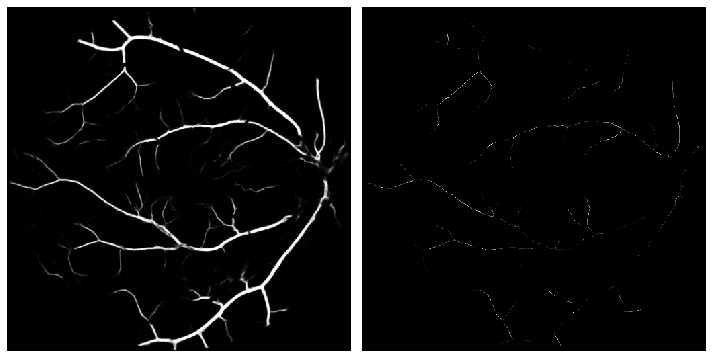

In [209]:
imshow_pair(probs[0,2], tv_loss[0,0].detach(), 
            vmin1=None,vmax1=None,vmin2=None,vmax2=None)

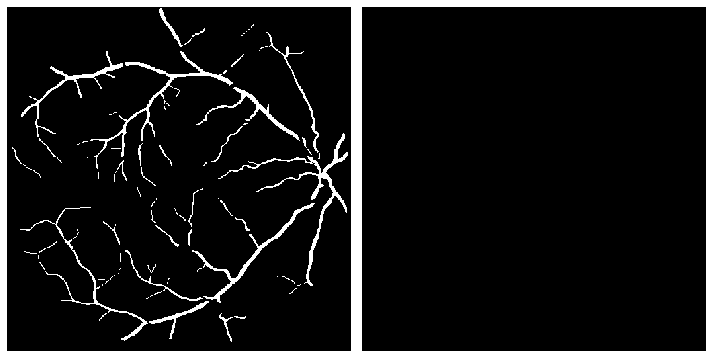

In [194]:
imshow_pair(perfect_probs[0,3], tv_loss_perfect[0,1].detach(), 
            vmin1=None,vmax1=None,vmin2=None,vmax2=None)

In [195]:
criterion  = MaskedTV(reduction='mean')

In [199]:
tv_loss  = 1000*criterion(logits, labels.squeeze(), sk_vein, sk_art)
tv_loss.item()

torch.Size([2, 512, 512])


0.0017505084397271276

In [201]:
tv_loss_perfect  = 1000*criterion(perfect_logits, labels.squeeze(), sk_vein, sk_art)
tv_loss_perfect.item()

torch.Size([2, 512, 512])


0.0